In [1]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf

train_dir = "..\isec-ic\\dataset\\train"
validation_dir = "..\isec-ic\\dataset\\valid"
test_dir = "..\isec-ic\\dataset\\test"

current_dir = os.path.dirname(os.path.realpath(__file__ if '__file__' in locals() else os.getcwd()))
train_dir = os.path.join(current_dir, train_dir)
validation_dir = os.path.join(current_dir, validation_dir)
test_dir = os.path.join(current_dir, test_dir)

categories = ["bacterialspot", "healthy","lateblight","leafmold", "mosaicvirus","yellowleafcurlvirus" ,"spidermite","septorialeafspot" ]

def load_images_from_folder(folder):
    images = []
    labels = []
    subfolders = os.listdir(folder)
    for subfolder in subfolders:
        category = subfolder.split("_")[-1].lower()
        if category in categories:
            print("Loading images from category: " + category + " and subfolder: " + subfolder)
            subfolder_path = os.path.join(folder, subfolder)
            for filename in os.listdir(subfolder_path):
                img = Image.open(os.path.join(subfolder_path, filename))
                img = img.resize((64, 64))
                img = np.array(img) / 255.0
                images.append(img)
                labels.append(categories.index(category))
        else:
            print("Category: " + category + " from subfolder " + subfolder + " is not in the list of categories.")
    return np.array(images), np.array(labels)


x_train, y_train = load_images_from_folder(train_dir)
x_validation, y_validation = load_images_from_folder(validation_dir)
x_test, y_test = load_images_from_folder(test_dir)

print("Images loaded successfully")

Loading images from category: spidermite and subfolder: Tomato__spidermite
Loading images from category: bacterialspot and subfolder: Tomato___Bacterialspot
Category: earlyblight from subfolder Tomato___Earlyblight is not in the list of categories.
Loading images from category: healthy and subfolder: Tomato___healthy
Loading images from category: lateblight and subfolder: Tomato___Lateblight
Loading images from category: leafmold and subfolder: Tomato___Leafmold
Loading images from category: septorialeafspot and subfolder: Tomato___Septorialeafspot
Category: targetspot from subfolder Tomato___Targetspot is not in the list of categories.
Loading images from category: mosaicvirus and subfolder: Tomato___Tomato_mosaicvirus
Loading images from category: yellowleafcurlvirus and subfolder: Tomato___Tomato_yellowleafcurlvirus
Loading images from category: bacterialspot and subfolder: Tomato___Bacterialspot
Category: earlyblight from subfolder Tomato___Earlyblight is not in the list of categor

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import roc_auc_score, make_scorer
from tensorflow.keras.utils import to_categorical

# Função para criar o modelo CNN
def create_cnn_model(dropout_rate, learning_rate):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(len(categories), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Teste o modelo com um conjunto fixo de parâmetros
#test_model = create_cnn_model(0.5, 0.001)  # Exemplo: dropout_rate=0.5, learning_rate=0.001
#test_model.fit(x_train, y_train, epochs=10, batch_size=32, verbose=1)
#y_pred = test_model.predict(x_train)
#y_true_one_hot = to_categorical(y_train, num_classes=len(categories))
#auc_score = roc_auc_score(y_true_one_hot, y_pred, multi_class='ovr', average='macro')
#print("AUC Score fora do RandomizedSearchCV:", auc_score)


Epoch 1/10
375/375 [==============================] - 2s 4ms/step - loss: 1.2019 - accuracy: 0.5903
Epoch 2/10
375/375 [==============================] - 2s 4ms/step - loss: 0.5981 - accuracy: 0.7932
Epoch 3/10
375/375 [==============================] - 2s 4ms/step - loss: 0.4635 - accuracy: 0.8398
Epoch 4/10
375/375 [==============================] - 2s 4ms/step - loss: 0.4172 - accuracy: 0.8524
Epoch 5/10
375/375 [==============================] - 2s 4ms/step - loss: 0.3733 - accuracy: 0.8673
Epoch 6/10
375/375 [==============================] - 2s 4ms/step - loss: 0.3415 - accuracy: 0.8789
Epoch 7/10
375/375 [==============================] - 2s 4ms/step - loss: 0.3186 - accuracy: 0.8858
Epoch 8/10
375/375 [==============================] - 2s 4ms/step - loss: 0.3005 - accuracy: 0.8912
Epoch 9/10
375/375 [==============================] - 2s 4ms/step - loss: 0.2792 - accuracy: 0.9025
Epoch 10/10
375/375 [==============================] - 2s 5ms/step - loss: 0.2688 - accuracy: 0.9056

In [12]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import numpy as np

class CustomKerasClassifier(KerasClassifier):
    def __init__(self, build_fn=None, **sk_params):
        super(CustomKerasClassifier, self).__init__(build_fn, **sk_params)

    def predict(self, x, **kwargs):
        # Prevendo as classes
        preds = self.model.predict(x, **kwargs)
        return np.argmax(preds, axis=-1)


# Distribuições de parâmetros
param_distributions = {
    'dropout_rate': np.linspace(0.1, 1.0, 10),
    'learning_rate': np.logspace(-3, -1, 10)
}

model = CustomKerasClassifier(build_fn=create_model, epochs=5, batch_size=32, verbose=1)

# Criar o objeto RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, 
                                   param_distributions=param_distributions, 
                                   n_iter=2, 
                                   cv=KFold(n_splits=5, shuffle=True, random_state=42), 
                                   scoring='accuracy', 
                                   random_state=42)
# Executar a pesquisa aleatória
random_search_result = random_search.fit(x_train, y_train)

# Imprimir os melhores parâmetros e o melhor score
print("Melhores parâmetros:", random_search_result.best_params_)
print("Melhor Score:", random_search_result.best_score_)

Epoch 1/5
300/300 [==============================] - 2s 5ms/step - loss: 2.5894 - accuracy: 0.1644
Epoch 2/5
300/300 [==============================] - 1s 4ms/step - loss: 2.0174 - accuracy: 0.1799
Epoch 3/5
300/300 [==============================] - 1s 4ms/step - loss: 2.0199 - accuracy: 0.1664
Epoch 4/5
300/300 [==============================] - 1s 4ms/step - loss: 2.0087 - accuracy: 0.1683
Epoch 5/5
300/300 [==============================] - 1s 4ms/step - loss: 2.0184 - accuracy: 0.1624
Epoch 1/5
300/300 [==============================] - 2s 5ms/step - loss: 2.8203 - accuracy: 0.1808
Epoch 2/5
300/300 [==============================] - 1s 4ms/step - loss: 2.0088 - accuracy: 0.1751
Epoch 3/5
300/300 [==============================] - 1s 4ms/step - loss: 2.0183 - accuracy: 0.1682
Epoch 4/5
300/300 [==============================] - 1s 4ms/step - loss: 2.0008 - accuracy: 0.1788
Epoch 5/5
300/300 [==============================] - 1s 4ms/step - loss: 1.9949 - accuracy: 0.1800
Epoch 1/5


Treinando o modelo com os melhores hiperparâmetros...
Epoch 1/20
375/375 [==============================] - 3s 6ms/step - loss: 1.2694 - accuracy: 0.6407 - val_loss: 0.5628 - val_accuracy: 0.8087
Epoch 2/20
375/375 [==============================] - 2s 6ms/step - loss: 0.4631 - accuracy: 0.8341 - val_loss: 0.3814 - val_accuracy: 0.8728
Epoch 3/20
375/375 [==============================] - 2s 6ms/step - loss: 0.3754 - accuracy: 0.8664 - val_loss: 0.4810 - val_accuracy: 0.8366
Epoch 4/20
375/375 [==============================] - 2s 6ms/step - loss: 0.3262 - accuracy: 0.8817 - val_loss: 0.3457 - val_accuracy: 0.8856
Epoch 5/20
375/375 [==============================] - 2s 6ms/step - loss: 0.2768 - accuracy: 0.8983 - val_loss: 0.3706 - val_accuracy: 0.8712
Epoch 6/20
375/375 [==============================] - 2s 6ms/step - loss: 0.2534 - accuracy: 0.9068 - val_loss: 0.3565 - val_accuracy: 0.8819
Epoch 7/20
375/375 [==============================] - 2s 6ms/step - loss: 0.2435 - accuracy: 0

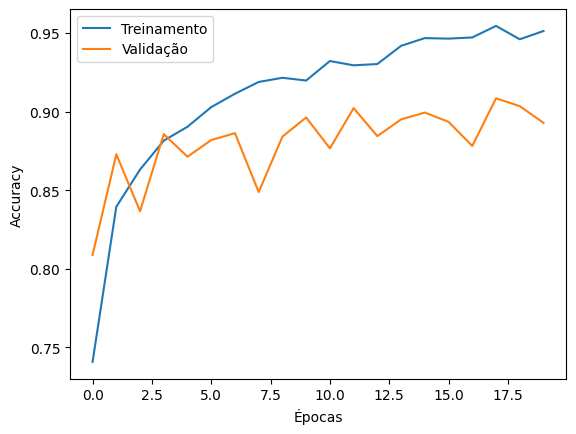

In [17]:
best_learning_rate = 0.004641588833612777
best_dropout_rate = 0.1


print("Treinando o modelo com os melhores hiperparâmetros...")
best_model = create_cnn_model(best_dropout_rate, best_learning_rate)
best_model_history = best_model.fit(x_train, y_train, epochs=20, batch_size=32, verbose=1, validation_data=(x_validation, y_validation))

best_train_accuracy = best_model_history.history['accuracy'][-1]
best_validation_accuracy = best_model_history.history['val_accuracy'][-1]

print("Melhor Accuracy de Treino:", best_train_accuracy)
print("Melhor Accuracy de Validação:", best_validation_accuracy)

import matplotlib.pyplot as plt

# Plotar as curvas de treino e validação
plt.plot(best_model_history.history['accuracy'], label='Treinamento')
plt.plot(best_model_history.history['val_accuracy'], label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [18]:
print("Avaliando o modelo no conjunto de teste...")
loss_test, test_accuracy = best_model.evaluate(x_test, y_test, verbose=0)

print(f"Acurácia no Teste: {test_accuracy}, Loss: {loss_test}")

Avaliando o modelo no conjunto de teste...
Acurácia no Teste: 0.8924999833106995, Loss: 0.4388124942779541
